In [34]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import cm, colors

from ecomplexity import ecomplexity
from ecomplexity import proximity

**1 -- data preparation**

In [2]:
# data IN
data = pd.read_csv("../data/languages.csv")

In [3]:
# filter functions
def drop_specifics_from_list(data, filter_list):
    """filter specific languages from list -- motivated by RM del Rio-Chanona et al 2023"""
    data = data[~data["language"].str.contains(filter_list, case=False, regex=True)]
    return data

def top_languages_filter(data, nr_languages):
    """keep top x number of languages ONLY"""
    top_languages = data.groupby(["language"])["num_pushers"].agg("sum").reset_index().sort_values(by="num_pushers", ascending=False)
    top_languages = list(top_languages["language"])[:nr_languages]
    data = data[data["language"].isin(top_languages)]
    return data
def drop_country_codes_from_list(data, country_list):
    data = data[~data["iso2_code"].isin(country_list)]
    return data

def dataframe_for_ecomplexity(data, focal_year, quarter_list):
    """aggregate and transform dataframe for ecomplexity functions"""
    data = data[(data["year"]==focal_year) & (data["quarter"].isin(quarter_list))]
    data = data\
        .groupby(["year", "iso2_code", "language"])["num_pushers"]\
        .agg("sum")\
        .reset_index()\
        .sort_values(by="num_pushers", ascending=False)    
    return data

In [4]:
prev_filter = "|".join(["yaml", "json", "text", "svg", "Markdown", "xml"])
df = drop_specifics_from_list(data, filter_list=prev_filter)
df = top_languages_filter(df, nr_languages=150)
df = drop_country_codes_from_list(df, country_list=["EU"])
df = dataframe_for_ecomplexity(df, focal_year=2020, quarter_list=[1,2,3,4])
print(df.shape)

(5693, 4)


In [5]:
# calculate country and language complexity
key_cols = {
    "time": "year",
    "loc": "iso2_code",
    "prod": "language",
    "val": "num_pushers",
}

cdf = ecomplexity(df, key_cols)

2020


In [6]:
# export
cdf.to_csv("../outputs/complexity_table.csv", sep=";", index=False)

In [7]:
cdf[["eci", "iso2_code"]].drop_duplicates().sort_values(by="eci", ascending=False).head(10)

,eci,iso2_code
4970,2.134917,DE
6532,2.102617,GB
19596,2.099405,US
6390,2.068886,FR
3266,2.003976,CA
9372,1.959863,JP
16472,1.950943,RU
4118,1.947756,CN
13916,1.943360,NL
994,1.916813,AU


In [8]:
cdf[["eci", "iso2_code"]].drop_duplicates().sort_values(by="eci", ascending=False).tail(10)

,eci,iso2_code
10366,-1.142982,LA
17750,-1.197457,SO
13064,-1.197457,MW
3124,-1.240106,BZ
2840,-1.240106,BW
2414,-1.240106,BN
10792,-1.240106,LR
1846,-1.240106,BF
1420,-1.240106,BB
12922,-1.240106,MV


In [9]:
cdf[["pci", "language"]].drop_duplicates().sort_values(by="pci", ascending=False).head(20)

,pci,language
60,2.735643,Liquid
48,2.718132,Haml
0,2.695782,AMPL
78,2.693775,OpenSCAD
35,2.686750,G-code
57,2.673040,LLVM
115,2.670293,SourcePawn
61,2.653580,Logos
24,2.653580,DTrace
122,2.652053,SystemVerilog


In [10]:
cdf[["pci", "language"]].drop_duplicates().sort_values(by="pci", ascending=False).tail(20)

,pci,language
2,0.076234,ASP.NET
14,0.060997,C#
128,-0.000651,TypeScript
110,-0.043670,Shell
92,-0.095134,Python
123,-0.146376,TSQL
58,-0.243049,Less
56,-0.280109,Kotlin
121,-0.325227,Swift
47,-0.435784,Hack


**2 -- complexity visuals**


In [24]:
def mcl_raw_matrix(df, key_columns, heatmap, size, ax=None):
    table = df[key_columns]
    
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[1],
        columns=key_columns[0],
        aggfunc=np.sum,
        margins=True,
        margins_name='total')

    table = table\
            .sort_values(by=["total"], ascending=False, axis=0)\
            .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    table = np.log10(table)
    table.replace([np.inf, -np.inf], 0, inplace=True)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.tick_params("y", labelsize=size-15)
        ax.tick_params(left = False, bottom = False)

        my_cmap = plt.cm.get_cmap('Blues')
        colors = my_cmap(table.values.tolist())

        sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,table.values.max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, orientation="vertical", pad=0.1, shrink=0.9925, aspect=40, ax=ax)
        cbar.ax.set_ylabel("Number of pushers", size=size)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.tick_params(labelsize=size-5)
        cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])
        cbar.set_ticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$'])

/opt/homebrew/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


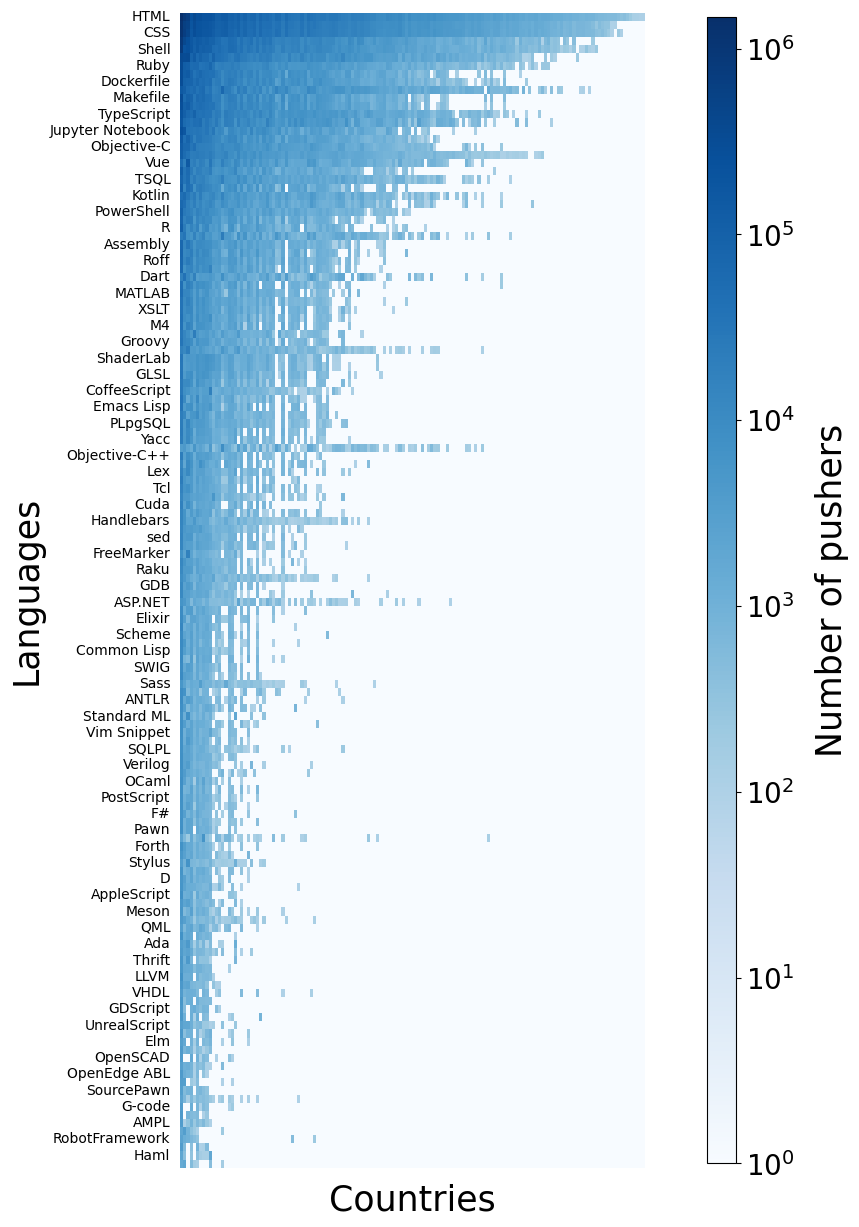

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8, 15))
mcl_raw_matrix(cdf, key_columns=["iso2_code", "language", "num_pushers"], heatmap=True, size=25, ax=ax)

In [26]:
def mcl_matrix(df, key_columns, heatmap, size, ax=None):
    table = df[key_columns]
    table.loc[table[key_columns[2]] >=1, key_columns[2]] = 1
    table.loc[table[key_columns[2]] < 1, key_columns[2]] = 0
    
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[1],
        columns=key_columns[0],
        aggfunc=np.sum,
        margins=True,
        margins_name='total')
    
    table = table\
        .sort_values(by=["total"], ascending=False, axis=0)\
        .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("RCA", size=size+2)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)
        

In [27]:
def mcc_matrix(df, key_columns, heatmap, size=18, ax=None):
    mat = mcl_matrix(df, key_columns, heatmap=False, size=size).values
    t_mat = mat.transpose()

    mccp = np.dot(t_mat, mat)
    mccp = pd.DataFrame(mccp, columns=list(mcl_matrix(df, key_columns, heatmap=False, size=size).columns))

    if heatmap==False:
        return mccp
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(mccp, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("Mcc' ", size=size)
        ax.set_xlabel("Countries", size=size)
        ax.set_ylabel("Countries", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)


def mll_matrix(df, key_columns, heatmap, size, ax=None):
    mat = mcl_matrix(df, key_columns, heatmap=False, size=size).values
    t_mat = mat.transpose()
    mllp = np.dot(mat, t_mat) 
    mllp = pd.DataFrame(mllp, columns=list(mcl_matrix(df, key_columns, heatmap=False, size=size).index))

    if heatmap==False:
        return mllp
    else:
        if ax is None:
            ax = plt.gca()
        sns.heatmap(mllp, cbar=False, cmap="Blues", ax=ax)
        ax.set_title("Mll' ", size=size+2)
        ax.set_xlabel("Languages", size=size)
        ax.set_ylabel("Languages", size=size)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)



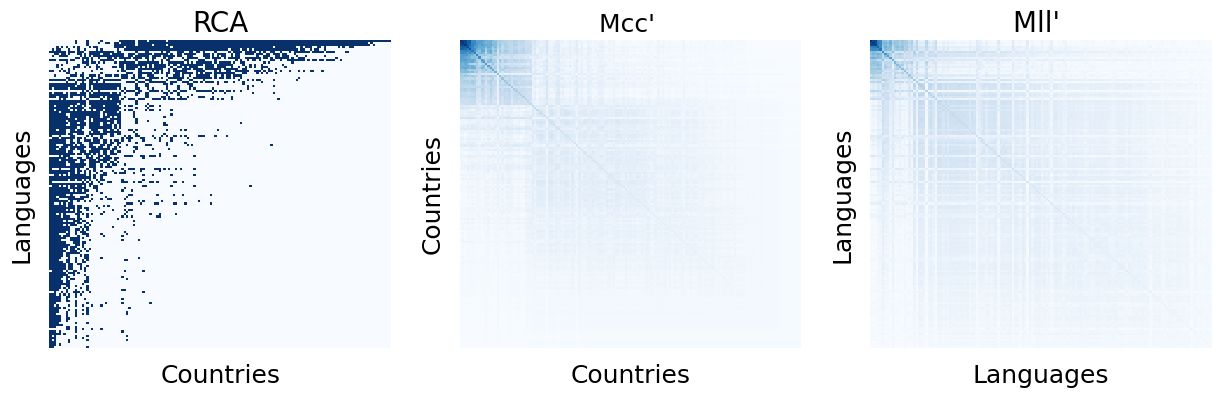

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
mcl_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[0])
mcc_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[1])
mll_matrix(cdf, key_columns=["iso2_code", "language", "rca"], heatmap=True, size=18, ax=ax[2])

In [43]:
def diversity_avg_ubiquity_complexity_scatter(df, ax=None):
    rca01 = df["rca"] >= 1
    df["rca01"] = rca01.astype(int) 
    df["w_ubi"] = df["rca01"] * df["ubiquity"]
    df["sum_w_ubi"] = df.groupby(["iso2_code"])["w_ubi"].transform("sum")    
    df["nr_rca01"] = df.groupby(["iso2_code"])["rca01"].transform("sum")
    df["mean_ubi"] = df["sum_w_ubi"] / df["nr_rca01"]

    df = df[["iso2_code", "eci", "diversity", "mean_ubi"]].drop_duplicates()
    #df["eci"] = (df["eci"] - df["eci"].min()) / (df["eci"].max() - df["eci"].min())

    vmin = min(df["eci"])
    vmax = max(df["eci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    eci_values = mapper.to_rgba(df["eci"].to_list())

    if ax is None:
        ax = plt.gca()
    ax.scatter(df["diversity"], df["mean_ubi"], color=eci_values, s=55)
    ax.set_xlabel("Language diversity", size=20)
    ax.set_ylabel("Average language ubiquity", size=20)
    ax.tick_params("x", labelsize=15)
    ax.tick_params("y", labelsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cbar = fig.colorbar(mapper, pad=0.02, shrink=0.975, ax=ax)
    cbar.ax.set_ylabel('Software complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

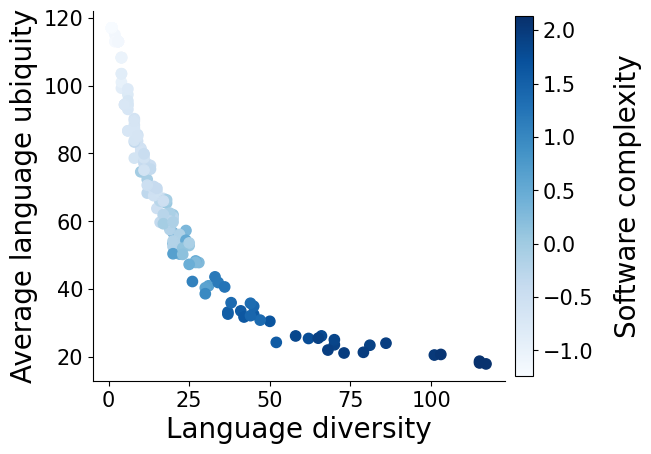

In [44]:
diversity_avg_ubiquity_complexity_scatter(cdf)

In [45]:
def ubiquity_avg_diversity_complexity_scatter(df, ax=None):
    rca01 = df["rca"] >= 1
    df["rca01"] = rca01.astype(int) 
    df["w_div"] = df["rca01"] * df["diversity"]
    df["sum_w_div"] = df.groupby(["language"])["w_div"].transform("sum")
    df["nr_rca01"] = df.groupby(["language"])["rca01"].transform("sum")
    df["mean_div"] = df["sum_w_div"] / df["nr_rca01"]

    df = df[["language", "pci", "ubiquity", "mean_div"]].drop_duplicates()

    vmin = min(df["pci"])
    vmax = max(df["pci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    pci_values = mapper.to_rgba(df["pci"].to_list())

    if ax is None:
        ax = plt.gca()
    ax.scatter(df["ubiquity"], df["mean_div"], color=pci_values, s=55)
    ax.set_xlabel("Language ubiquity", size=20)
    ax.set_ylabel("Average language diversity", size=20)
    ax.tick_params("x", labelsize=15)
    ax.tick_params("y", labelsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cbar = fig.colorbar(mapper, pad=0.02, shrink=0.975, ax=ax)
    cbar.ax.set_ylabel('Language complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

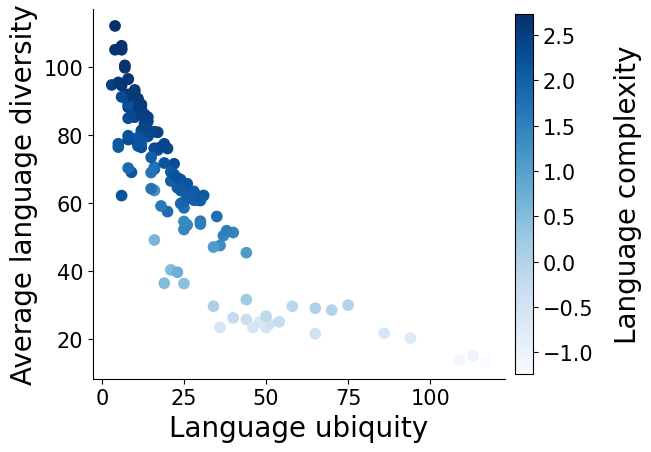

In [46]:
ubiquity_avg_diversity_complexity_scatter(cdf)

In [47]:
def complexity_complexity_matrix(df, heatmap, ax=None):
    # to sort location by eci
    location_sorter = df[["iso2_code", "eci"]]\
        .drop_duplicates()\
        .sort_values(by="eci", ascending=False)

    # only categories w/ RCA
    table = df[df["rca"] >= 1]
    table = table[["iso2_code", "language", "pci"]].drop_duplicates()
    
    table = pd.pivot_table(table,
        values="pci",
        index=["iso2_code"],
        columns=["language"],
        aggfunc=np.mean,
        margins=True,
        margins_name='total')
    
    # add the location_sorter and sort
    table = pd.merge(
        table,
        location_sorter,
        on="iso2_code",
        how="left"
    )

    table = table.sort_values(by=["eci"], ascending=False, axis=0)\
        .set_index("iso2_code")\
        .sort_values(by=["total"], ascending=False, axis=1)

    # remove supporter rows and cols
    table = table.drop(["eci"], axis=1).drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()

    sns.heatmap(table, cbar=False, cmap="Blues", ax=ax)
    ax.set_xlabel("Languages sorted by \n their complexity", size=20)
    ax.set_ylabel("Countries sorted by \n their complexity", size=20)
    #ax.set_xticklabels("")
    #ax.set_yticklabels("")
    ax.tick_params(left = False, bottom = False)

    # colorbar settings
    vmin = min(df["pci"])
    vmax = max(df["pci"])
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    cbar = fig.colorbar(mapper, shrink=0.975, pad=0.02, ax=ax)
    cbar.ax.set_ylabel('Software complexity', rotation=90, labelpad=15, fontsize=20)
    cbar.ax.tick_params(labelsize=15)

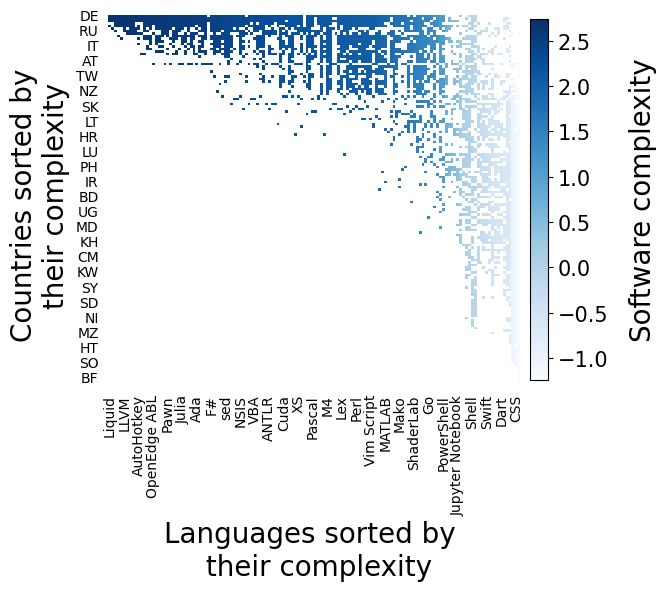

In [48]:
complexity_complexity_matrix(cdf, heatmap=True)

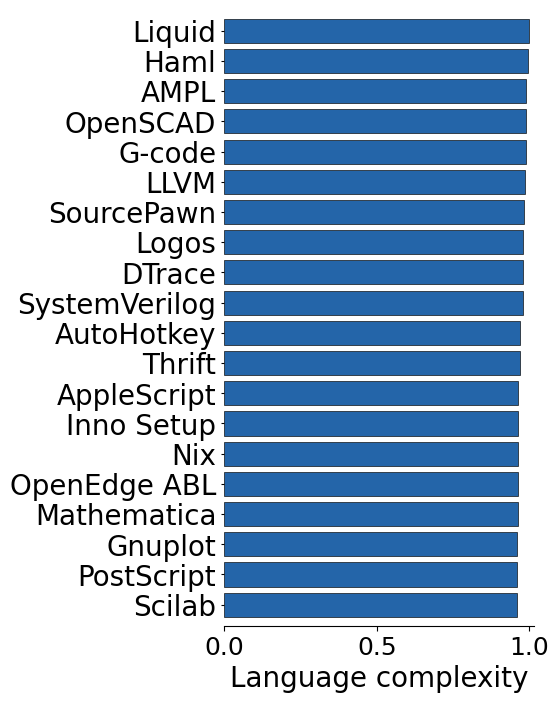

In [64]:
def poi_complexity_plot_top10(data, label_size, ax=None):
    data = data[["language", "pci"]].drop_duplicates()
    data["pci_norm"] = (data["pci"] - data["pci"].min()) / (data["pci"].max() - data["pci"].min())
    data = data.sort_values(by=["pci_norm"], ascending=True)
    data = data.iloc[-20:,]

    if ax is None:
        ax = plt.gca()
    ax.barh(data["language"], data["pci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Language complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
poi_complexity_plot_top10(cdf, label_size=20, ax=ax)

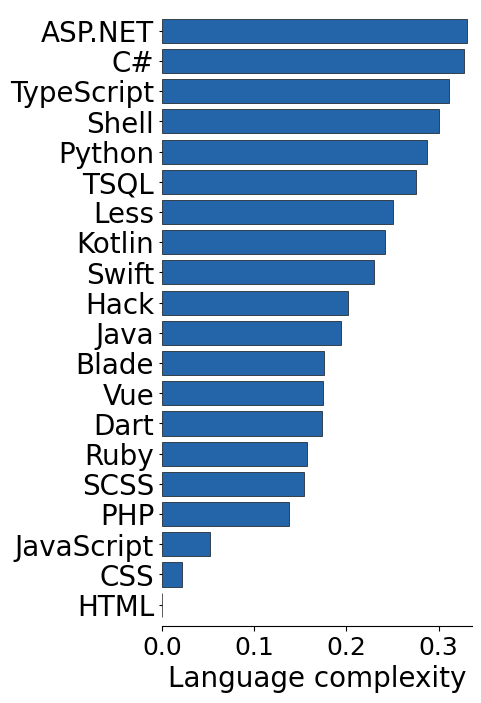

In [63]:
def poi_complexity_plot_bottom10(data, label_size, ax=None):
    data = data[["language", "pci"]].drop_duplicates()
    data["pci_norm"] = (data["pci"] - data["pci"].min()) / (data["pci"].max() - data["pci"].min())
    data = data.sort_values(by=["pci_norm"], ascending=False)
    data = data.iloc[-20:,].sort_values(by=["pci_norm"], ascending=True)

    if ax is None:
        ax = plt.gca()
    ax.barh(data["language"], data["pci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Language complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
poi_complexity_plot_bottom10(cdf, label_size=20, ax=ax)

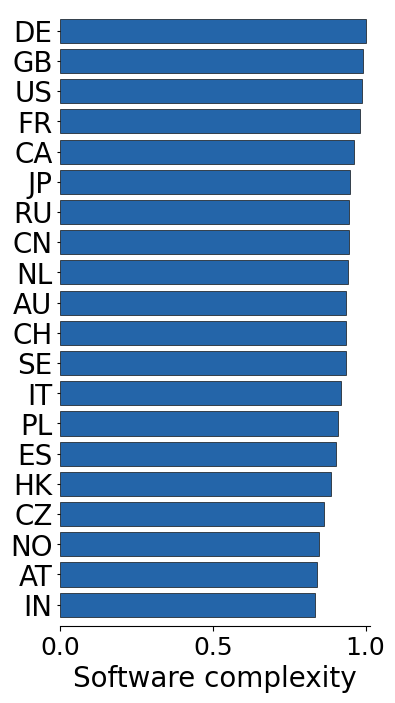

In [66]:
def software_complexity_plot_top10(data, label_size, ax=None):
    data = data[["iso2_code", "eci"]].drop_duplicates()
    data["eci_norm"] = (data["eci"] - data["eci"].min()) / (data["eci"].max() - data["eci"].min())
    data = data.sort_values(by=["eci_norm"], ascending=True)
    data = data.iloc[-20:,]

    if ax is None:
        ax = plt.gca()
    ax.barh(data["iso2_code"], data["eci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Software complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
software_complexity_plot_top10(cdf, label_size=20, ax=ax)

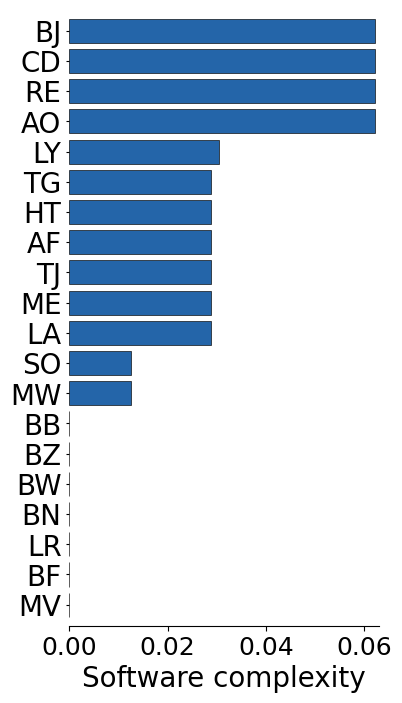

In [68]:
def software_complexity_plot_bottom10(data, label_size, ax=None):
    data = data[["iso2_code", "eci"]].drop_duplicates()
    data["eci_norm"] = (data["eci"] - data["eci"].min()) / (data["eci"].max() - data["eci"].min())
    data = data.sort_values(by=["eci_norm"], ascending=False)
    data = data.iloc[-20:,].sort_values(by=["eci_norm"], ascending=True)

    if ax is None:
        ax = plt.gca()
    ax.barh(data["iso2_code"], data["eci_norm"], color="#2465a9", edgecolor="black", linewidth=0.45)

    ax.margins(0.015, tight=True)
    ax.set_xlabel("Software complexity", size=label_size)
    ax.tick_params("y", size=2, labelsize=label_size)
    ax.tick_params("x", labelsize=label_size-2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(4,8))
software_complexity_plot_bottom10(cdf, label_size=20, ax=ax)

**3 -- github space visuals**

In [13]:
# github space
space_df = proximity(df, key_cols)

2020


In [15]:
# export
space_df.to_csv("../outputs/space_table.csv", sep=";", index=False)

In [18]:
def edgelist_for_github_space(data, key_columns):
    """transform the ecomplexity proximity output for visualization"""
    data = data[key_columns]

    # drop zero -- non-existing edges
    data = data[data[key_columns[2]] > 0]

    # drop self loops
    data = data[data[key_columns[0]] != data[key_columns[1]]]
    return data

space_table = edgelist_for_github_space(space_df, key_columns=["language_1", "language_2", "proximity"])


In [19]:
def maximum_spanning_tree(data, key_columns):
    table = data.copy()
    table["distance"] = 1.0 / table[key_columns[2]]
    G = nx.from_pandas_edgelist(table, source = key_columns[0], target = key_columns[1], edge_attr = ["distance", key_columns[2]])
    T = nx.minimum_spanning_tree(G, weight = "distance")
    table2 = nx.to_pandas_edgelist(T)
    table2 = table2[table2[key_columns[2]] > 0]
    table2.rename(columns = {"source": key_columns[0], "target": key_columns[1], key_columns[2]: "score"}, inplace = True)
    table = pd.merge(
        table,
        table2,
        on=key_columns[0:2]
    )  
    table["edge"] = table.apply(lambda x: "%s-%s" % (min(x[key_columns[0]], x[key_columns[1]]), max(x[key_columns[0]], x[key_columns[1]])), axis = 1)
    table = table.drop_duplicates(subset = ["edge"])
    table = table.drop("edge", 1)
    return table[key_columns]

In [20]:
# NEED to add edges above threshold
mst_el = maximum_spanning_tree(space_table, key_columns=["language_1", "language_2", "proximity"])

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_39570/2237830232.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)


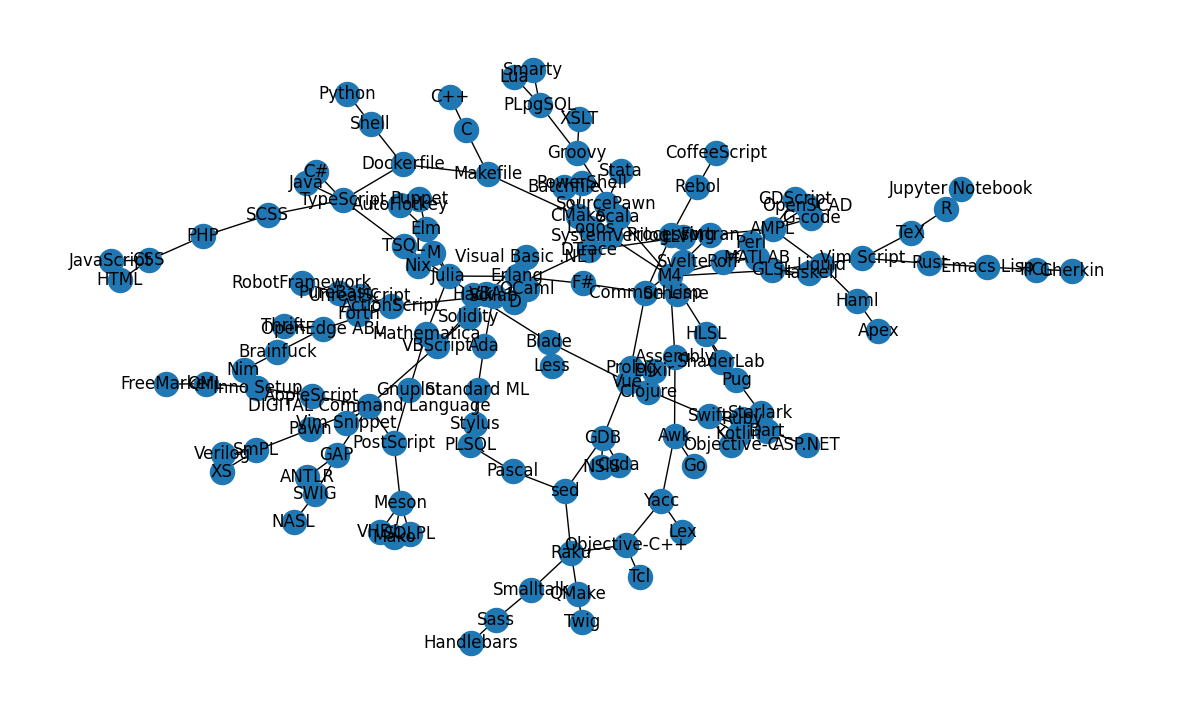

In [29]:
# network visual
mst_graph = nx.from_pandas_edgelist(mst_el, source="language_1", target="language_2")

fig, ax = plt.subplots(1,1, figsize=(15,9))
nx.draw(mst_graph, with_labels=True, ax=ax)

In [156]:
# dataframe for regression
